In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from datetime import datetime
# -------------------------
# 1. Load funding rate
# -------------------------
df = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))
df = df.sort_values("fundingDateTime").drop("formattedFundingDateTime",axis = 1).drop("symbol",axis = 1)

# -------------------------
# 2. Create Target: next 6 periods cumulative funding
# -------------------------
horizon_periods = 6   # 6 periods = 48 hours (2 days)
df["target_48h"] = df["fundingRate"].rolling(horizon_periods).sum().shift(-horizon_periods)

df = df.dropna()

# -------------------------
# 3. Feature Engineering
# -------------------------
def add_features(df):
    # Lag features (previous periods)
    for lag in [1, 2, 3, 4, 6, 12]:
        df[f"lag_{lag}p"] = df["fundingRate"].shift(lag)

    # Rolling stats (period-based)
    df["roll_mean_3p"]  = df["fundingRate"].rolling(3).mean()
    df["roll_mean_6p"]  = df["fundingRate"].rolling(6).mean()
    df["roll_std_6p"]   = df["fundingRate"].rolling(6).std()

    # Time features
    df["hour"] = df["fundingDateTime"].dt.hour
    df["dayofweek"] = df["fundingDateTime"].dt.dayofweek

    return df

df = add_features(df)

df = df.dropna()

# -------------------------
# 4. Select Features
# -------------------------
features = [c for c in df.columns 
            if c not in ["fundingDateTime", "fundingRate", "target_48h"]]

df = df.sort_values("fundingDateTime")

# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train["target_48h"]

X_test = test[features]
y_test = test["target_48h"]

# -------------------------
# 6. Train LGBM Model
# -------------------------
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])



C:\Users\timkf\AppData\Local\Temp\ipykernel_27528\906771001.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 2496, number of used features: 12
[LightGBM] [Info] Start training from score 0.000198
MAE: 0.0001778634301375528
Latest predicted 48h cumulative funding: 2.5031022229497602e-05


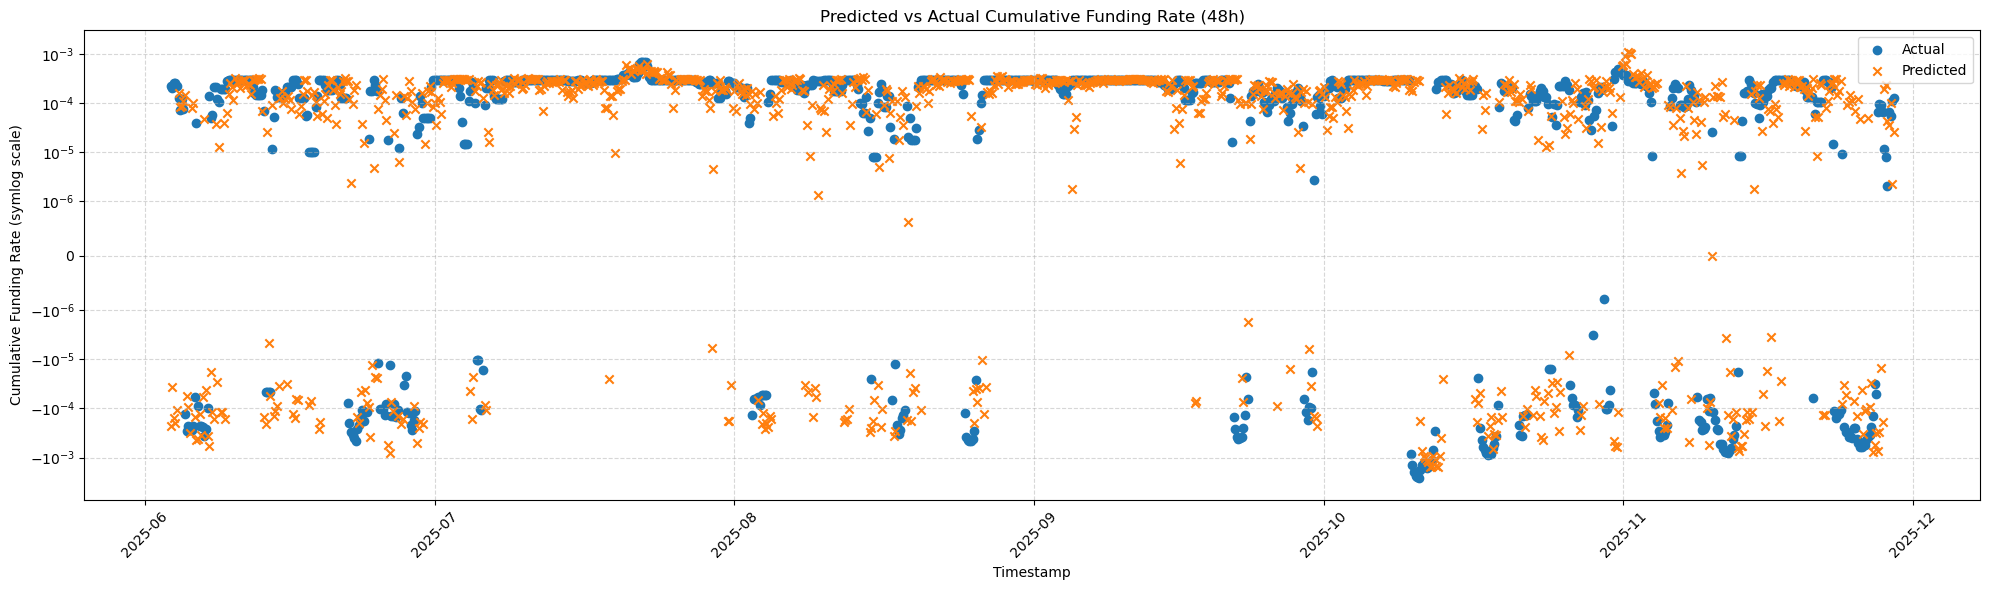

In [43]:
import matplotlib.pyplot as plt

# Extract corresponding timestamps for test set
test_timestamps = df.iloc[len(df) - len(y_test):]["fundingDateTime"]

plt.figure(figsize=(20,6))
plt.scatter(test_timestamps, y_test, label="Actual", marker='o')
plt.scatter(test_timestamps, preds, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Cumulative Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Cumulative Funding Rate (48h)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np

# --- Load datasets ---
funding = pd.read_csv("D:\\Homework\\QF634\\project\\BNBUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))
funding = funding.sort_values("fundingDateTime").drop("formattedFundingDateTime",axis = 1).drop("symbol",axis = 1)
funding.rename(columns={'fundingDateTime': 'timestamp'}, inplace=True)

spot = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\BNBUSDT_5m_binance_spot_historical_data.json',lines=True)           # columns: timestamp, open, high, low, close, volume, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
future = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\BNBUSDT_5m_binance_futures_historical_data.json',lines=True) 

# --- Convert timestamp to datetime and set index ---
for df in [funding, spot, future]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round('S')

funding.set_index('timestamp', inplace=True)
spot.set_index('timestamp', inplace=True)
future.set_index('timestamp', inplace=True)

print(funding.head)
print(spot.head)
print(future.head)



C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1268195025.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv("D:\\Homework\\QF634\\project\\BNBUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))


<bound method NDFrame.head of                      fundingRate   markPrice
timestamp                                   
2020-02-10 08:00:00     0.000000         NaN
2020-02-10 16:00:00     0.003046         NaN
2020-02-11 00:00:00     0.001616         NaN
2020-02-11 08:00:00     0.002613         NaN
2020-02-11 16:00:00     0.001556         NaN
...                          ...         ...
2025-11-28 16:00:00     0.000000  902.270000
2025-11-29 00:00:00     0.000000  887.547899
2025-11-29 08:00:00     0.000000  879.470000
2025-11-29 16:00:00     0.000000  881.250000
2025-11-30 00:00:00     0.000000  873.260000

[6360 rows x 2 columns]>
<bound method NDFrame.head of                          open      high       low     close    volume  \
timestamp                                                               
2020-01-01 00:05:00   13.7010   13.7105   13.7000   13.7079  5018.620   
2020-01-01 00:10:00   13.7125   13.7182   13.7000   13.7041  4358.320   
2020-01-01 00:15:00   13.7051   13.71

C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1268195025.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1268195025.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1268195025.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')


In [2]:
def rolling_features(df, prefix, window='1H'):
    df_feat = df.copy()
    
    # 1. Returns
    df_feat['return'] = df_feat['close'].pct_change()
    
    # 2. Rolling volatility
    df_feat[f'{prefix}_volatility_roll'] = df_feat['return'].rolling(window=window).std()
    
    # 3. Momentum (price change over window)
    df_feat[f'{prefix}_momentum'] = df_feat['close'].pct_change(periods=int(pd.Timedelta(window)/pd.Timedelta('5min')))
    
    # 4. Max drawdown in rolling window
    roll_max = df_feat['close'].rolling(window=window).max()
    df_feat[f'{prefix}_max_drawdown'] = (df_feat['close'] - roll_max) / roll_max
    
    return df_feat

# --- Add rolling features (1-hour rolling example) ---
spot = rolling_features(spot, 'spot', window='1h')
future = rolling_features(future, 'future', window='1h')

# --- Resample 5-min data to 8h aggregates ---
def resample_5min_to_8h(df, prefix):
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'quote_asset_volume': 'sum',
        'number_of_trades': 'sum',
        'taker_buy_base_asset_volume': 'sum',
        'taker_buy_quote_asset_volume': 'sum',
        f'return': 'mean',
        f'{prefix}_volatility_roll': 'mean',
        f'{prefix}_momentum': 'mean',
        f'{prefix}_max_drawdown': 'min'
    }
    df_4h = df.resample('4h').agg(agg_dict)
    
    # Taker ratio
    df_4h[f'{prefix}_taker_ratio'] = df_4h['taker_buy_base_asset_volume'] / (df_4h['volume'] + 1e-9)
    
    # Rename columns with prefix
    df_4h = df_4h.add_prefix(f'{prefix}_')
    
    return df_4h

spot_4h = resample_5min_to_8h(spot, 'spot')
future_4h = resample_5min_to_8h(future, 'future')

print(spot_4h.head)
print(future_4h.head)

<bound method NDFrame.head of                      spot_open  spot_high  spot_low  spot_close  spot_volume  \
timestamp                                                                      
2020-01-01 00:00:00    13.7010    13.8500   13.6903     13.8170   220394.930   
2020-01-01 04:00:00    13.8157    13.8501   13.7428     13.7608   132921.020   
2020-01-01 08:00:00    13.7618    13.8125   13.6813     13.7190   171250.420   
2020-01-01 12:00:00    13.7190    13.8692   13.7168     13.8223   150269.000   
2020-01-01 16:00:00    13.8223    13.8671   13.6715     13.7229   150101.290   
...                        ...        ...       ...         ...          ...   
2025-11-30 00:00:00   872.9000   878.9400  869.5600    875.5900     8799.637   
2025-11-30 04:00:00   875.6000   876.9500  870.1300    874.7800     8109.893   
2025-11-30 08:00:00   874.7900   879.6900  874.4000    876.7200    11745.988   
2025-11-30 12:00:00   876.7200   897.8900  875.7000    893.9900    41331.250   
2025-11-30

In [3]:
# --- Helper functions for rolling features ---

# --- Merge features with funding rate ---
df_final = funding.merge(spot_4h, left_index=True, right_index=True, how='left').merge(future_4h, left_index=True, right_index=True, how='left')

print(df_final.head)



<bound method NDFrame.head of                      fundingRate   markPrice  spot_open  spot_high  spot_low  \
timestamp                                                                      
2020-02-10 08:00:00     0.000000         NaN    24.7712    25.7935   23.9000   
2020-02-10 16:00:00     0.003046         NaN    25.1016    25.4780   24.9239   
2020-02-11 00:00:00     0.001616         NaN    25.1450    25.2009   24.3000   
2020-02-11 08:00:00     0.002613         NaN    24.5366    25.1400   24.4000   
2020-02-11 16:00:00     0.001556         NaN    24.9588    25.7000   24.5060   
...                          ...         ...        ...        ...       ...   
2025-11-28 16:00:00     0.000000  902.270000   902.0000   902.3300  876.1500   
2025-11-29 00:00:00     0.000000  887.547899   887.2000   889.0000  883.4700   
2025-11-29 08:00:00     0.000000  879.470000   879.0700   882.2500  877.4900   
2025-11-29 16:00:00     0.000000  881.250000   880.9200   881.7600  868.2500   
2025-11-30

In [4]:
# --- Lag features (past 1-3 intervals) ---
lags = [1, 2, 3, 4, 6]
for lag in lags:
    df_final[f'funding_rate_lag_{lag}'] = df_final['fundingRate'].shift(lag)
    for col in df_final.columns:
        if 'spot_' in col or 'future_' in col:
            df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)

# --- Drop NaNs from lagging ---
df_final_lagged = df_final.dropna()
df_final_lagged.reset_index(inplace=True)

print("Feature dataset with rolling features ready for ML:")
print(df_final_lagged.head)

C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Feature dataset with rolling features ready for ML:
<bound method NDFrame.head of                timestamp  fundingRate   markPrice  spot_open  spot_high  \
0    2023-10-31 08:00:00     0.000094  226.017394     225.90     228.40   
1    2023-10-31 16:00:00     0.000064  224.580000     224.50     226.20   
2    2023-11-01 00:00:00     0.000033  226.350000     226.30     227.00   
3    2023-11-01 08:00:00     0.000093  224.720000     224.60     225.10   
4    2023-11-01 16:00:00     0.000007  223.397808     223.30     227.80   
...                  ...          ...         ...        ...        ...   
2278 2025-11-28 16:00:00     0.000000  902.270000     902.00     902.33   
2279 2025-11-29 00:00:00     0.000000  887.547899     887.20     889.00   
2280 2025-11-29 08:00:00     0.000000  879.470000     879.07     882.25   
2281 2025-11-29 16:00:00     0.000000  881.250000     880.92     881.76   
2282 2025-11-30 00:00:00     0.000000  873.260000     872.90     878.94   

      spot_low  s

C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)
C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1264423611.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

horizon_periods = 6   # 6 periods = 24 hour, 6 period
df_final_lagged["target"] = df_final_lagged["fundingRate"].rolling(horizon_periods).sum().shift(-horizon_periods)
df = df_final_lagged.dropna()

features = [c for c in df.columns 
            if c not in ["timestamp", "fundingRate", "target"]]

df = df.sort_values("timestamp")

# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train["target"]

X_test = test[features]
y_test = test["target"]

# -------------------------
# 6. Train LGBM Model
# -------------------------
params = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",

    # ----- Stable params for spiky funding rate -----
    "learning_rate": 0.008,
    "num_leaves": 32,
    "max_depth": 5,

    "min_child_samples": 100,
    "min_child_weight": 1e-3,
    "lambda_l1": 2,
    "lambda_l2": 8,

    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "feature_fraction": 0.7,

    "n_estimators": 2000,
}

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=32,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])

C:\Users\timkf\AppData\Local\Temp\ipykernel_13448\1263336805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_lagged["target"] = df_final_lagged["fundingRate"].rolling(horizon_periods).sum().shift(-horizon_periods)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230010
[LightGBM] [Info] Number of data points in the train set: 1593, number of used features: 902
[LightGBM] [Info] Start training from score -0.000206


NameError: name 'mean_absolute_error' is not defined

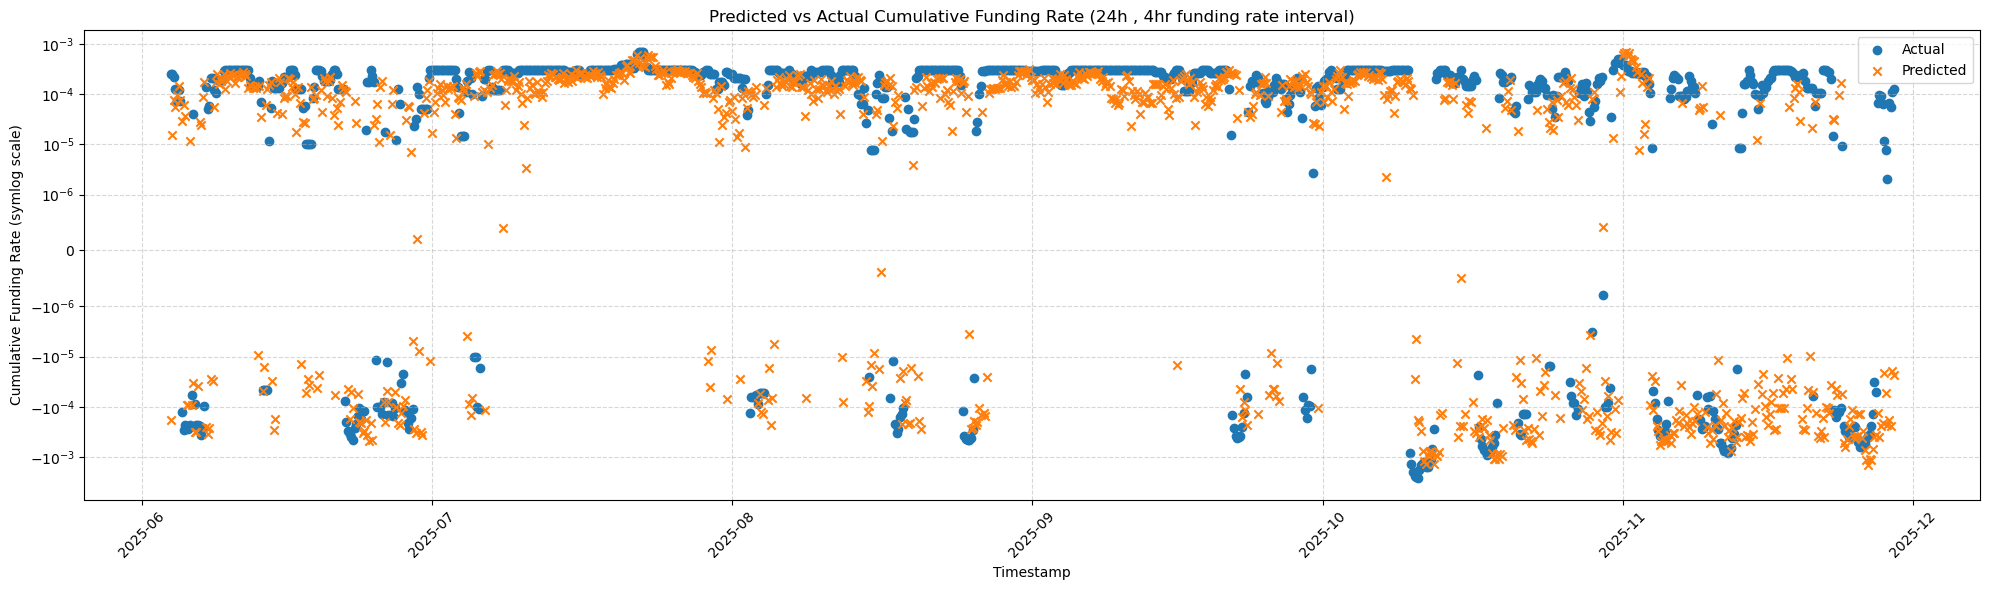

In [128]:
import matplotlib.pyplot as plt

# Extract corresponding timestamps for test set
test_timestamps = df.iloc[len(df) - len(y_test):]["timestamp"]

plt.figure(figsize=(20,6))
plt.scatter(test_timestamps, y_test, label="Actual", marker='o')
plt.scatter(test_timestamps, preds, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Cumulative Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Cumulative Funding Rate (24h , 4hr funding rate interval)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()